In [4]:
import numpy as np

# Define the characteristic function
def compute_characteristic_function(u, params, S0, r, q, T, model):
    if model == 'BS':
        volatility = params[0]
        drift = np.log(S0) + (r - q - volatility**2 / 2) * T
        diffusion = volatility * np.sqrt(T)
        phi = np.exp(1j * drift * u - (diffusion * u)**2 / 2)
    elif model == 'Heston':
        kappa, theta, sigma, rho, v0 = params
        temp1 = kappa - 1j * rho * sigma * u
        g = np.sqrt(sigma**2 * (u**2 + 1j * u) + temp1**2)
        power_term = 2 * kappa * theta / sigma**2
        numerator = (kappa * theta * T * temp1) / sigma**2 + 1j * u * T * r + 1j * u * np.log(S0)
        log_denominator = power_term * np.log(
            np.cosh(g * T / 2) + (temp1 / g) * np.sinh(g * T / 2))
        temp2 = ((u**2 + 1j * u) * v0) / (g / np.tanh(g * T / 2) + temp1)
        log_phi = numerator - log_denominator - temp2
        phi = np.exp(log_phi)
    elif model == 'VG':
        sigma, nu, theta = params
        if nu == 0:
            mu = np.log(S0) + (r - q - theta - 0.5 * sigma**2) * T
            phi = np.exp(1j * u * mu) * np.exp((1j * theta * u - 0.5 * sigma**2 * u**2) * T)
        else:
            mu = np.log(S0) + (r - q + np.log(1 - theta * nu - 0.5 * sigma**2 * nu) / nu) * T
            phi = np.exp(1j * u * mu) * (1 - 1j * nu * theta * u + 0.5 * nu * sigma**2 * u**2)**(-T / nu)
    return phi

# FFT-based option pricing
def calculate_fft_values(params, S0, K, r, q, T, alpha, eta, n, model):
    N = 2**n
    delta = (2 * np.pi / N) / eta
    beta = np.log(K)
    discount_factor = np.exp(-r * T)

    nuJ = np.arange(N) * eta
    psi_nuJ = compute_characteristic_function(nuJ - (alpha + 1) * 1j, params, S0, r, q, T, model) / (
              (alpha + 1j * nuJ) * (alpha + 1 + 1j * nuJ))

    km_values = beta + delta * np.arange(N)
    w_values = eta * np.ones(N)
    w_values[0] = eta / 2

    x_values = np.exp(-1j * beta * nuJ) * discount_factor * psi_nuJ * w_values
    y_values = np.fft.fft(x_values)

    cT_km_values = np.exp(-alpha * km_values) / np.pi * np.real(y_values)
    return km_values, cT_km_values

# Pricing puts
def calculate_put_prices(params, S0, K, r, q, T, model, alpha_values, eta_values, n_values):
    num_prices = len(eta_values) * len(n_values) * len(alpha_values)
    put_matrix = np.zeros([num_prices, 4])
    i = 0
    for eta in eta_values:
        for n in n_values:
            for alpha in alpha_values:
                k_values, option_values = calculate_fft_values(params, S0, K, r, q, T, alpha, eta, n, model)
                put = option_values[0]  # Taking the first strike value
                put_matrix[i] = [eta, n, alpha, put]
                i += 1
    return put_matrix

# Example usage
S0 = 100
K = 80
r = 0.055
q = 0.03
T = 1
model = 'BS'
params = [0.3]  # Volatility for BS model
alpha_values = [1, 1.5]
eta_values = [0.25, 0.5]
n_values = [12, 14]

# Calculate and display prices
put_prices = calculate_put_prices(params, S0, K, r, q, T, model, alpha_values, eta_values, n_values)
print("eta\tN\talpha\tput")
for row in put_prices:
    print(f"{row[0]:.2f}\t2^{int(row[1])}\t{row[2]:.2f}\t{row[3]:.4f}")


eta	N	alpha	put
0.25	2^12	1.00	24.2522
0.25	2^12	1.50	24.2522
0.25	2^14	1.00	24.2522
0.25	2^14	1.50	24.2522
0.50	2^12	1.00	24.2525
0.50	2^12	1.50	24.2522
0.50	2^14	1.00	24.2525
0.50	2^14	1.50	24.2522


## Introduction and Libraries

In [5]:
# Pricing Options using Fast Fourier Transform (FFT)
# Models Covered: Black-Scholes, Heston, and Variance-Gamma

# Importing Required Libraries
import numpy as np
import matplotlib.pyplot as plt


## General Parameters

In [6]:
# General Parameters for Option Pricing
S0 = 100  # Initial stock price
K = 80    # Strike price
k = np.log(K)  # Log strike price
r = 0.055  # Risk-free interest rate
q = 0.03   # Dividend yield
T = 1.0    # Time to maturity (1 year)

# FFT Parameters
n = 12           # Exponent for 2^n
N = 2 ** n       # Number of steps
eta = 0.25       # Integration step size
alpha = 1.0      # Damping factor
lambda_ = (2 * np.pi / N) / eta  # Log-strike step size
beta = np.log(K)  # Log-strike value


## Characteristic Function Computation

In [7]:
# Function to Compute Characteristic Function for Black-Scholes, Heston, and Variance-Gamma Models
def compute_characteristic_function(u, params, S0, r, q, T, model):
    if model == 'BS':  # Black-Scholes
        volatility = params[0]
        drift = np.log(S0) + (r - q - 0.5 * volatility**2) * T
        diffusion = volatility * np.sqrt(T)
        phi = np.exp(1j * drift * u - 0.5 * (diffusion * u)**2)
    elif model == 'Heston':  # Heston
        kappa, theta, sigma, rho, v0 = params
        temp1 = kappa - 1j * rho * sigma * u
        g = np.sqrt(sigma**2 * (u**2 + 1j * u) + temp1**2)
        power_term = 2 * kappa * theta / sigma**2
        log_numerator = np.log(np.cosh(g * T / 2) + (temp1 / g) * np.sinh(g * T / 2))
        log_denominator = (u**2 + 1j * u) * v0 / (g / np.tanh(g * T / 2) + temp1)
        phi = np.exp(1j * u * np.log(S0) + r * T * 1j * u - log_numerator - log_denominator)
    elif model == 'VG':  # Variance-Gamma
        sigma, nu, theta = params
        if nu == 0:
            mu = np.log(S0) + (r - q - theta - 0.5 * sigma**2) * T
            phi = np.exp(1j * u * mu) * np.exp((1j * theta * u - 0.5 * sigma**2 * u**2) * T)
        else:
            mu = np.log(S0) + (r - q + np.log(1 - theta * nu - 0.5 * sigma**2 * nu) / nu) * T
            phi = np.exp(1j * u * mu) * ((1 - 1j * nu * theta * u + 0.5 * nu * sigma**2 * u**2)**(-T / nu))
    return phi


## FFT Implementation

In [8]:
# FFT Function to Calculate Option Prices
def calculate_fft_values(params, S0, K, r, q, T, alpha, eta, n, model):
    N = 2 ** n
    delta = (2 * np.pi / N) / eta
    beta = np.log(K)
    
    # Discount Factor
    discount_factor = np.exp(-r * T)
    
    # Range of Integration (nu_j)
    nuJ = np.arange(N) * eta
    psi_nuJ = compute_characteristic_function(nuJ - (alpha + 1) * 1j, params, S0, r, q, T, model) / (
        (alpha + 1j * nuJ) * (alpha + 1 + 1j * nuJ)
    )
    
    # FFT Computation
    km_values = beta + delta * np.arange(N)
    w_values = eta * np.ones(N)
    w_values[0] = eta / 2  # Adjusting the first weight
    x_values = np.exp(-1j * beta * nuJ) * discount_factor * psi_nuJ * w_values
    y_values = np.fft.fft(x_values)
    cT_km_values = (np.exp(-alpha * km_values) / np.pi) * np.real(y_values)
    
    return km_values, cT_km_values


## Pricing Options and Visualization

In [9]:
# Pricing Options for Black-Scholes, Heston, and Variance-Gamma Models
def price_options_and_plot(params, S0, K, r, q, T, alpha, eta, n, model, title):
    km_values, cT_km_values = calculate_fft_values(params, S0, K, r, q, T, alpha, eta, n, model)
    
    # Convert Log-Strike to Normal Strike Prices
    strikes = np.exp(km_values)
    
    # Plotting the Results
    plt.figure(figsize=(10, 6))
    plt.plot(strikes, cT_km_values, label=f"{model} Option Prices", color='blue')
    plt.axvline(x=K, color='red', linestyle='--', label='Strike Price (K)')
    plt.title(f"{title} Option Prices using FFT")
    plt.xlabel("Strike Price")
    plt.ylabel("Option Price")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return strikes, cT_km_values


## Running for Models

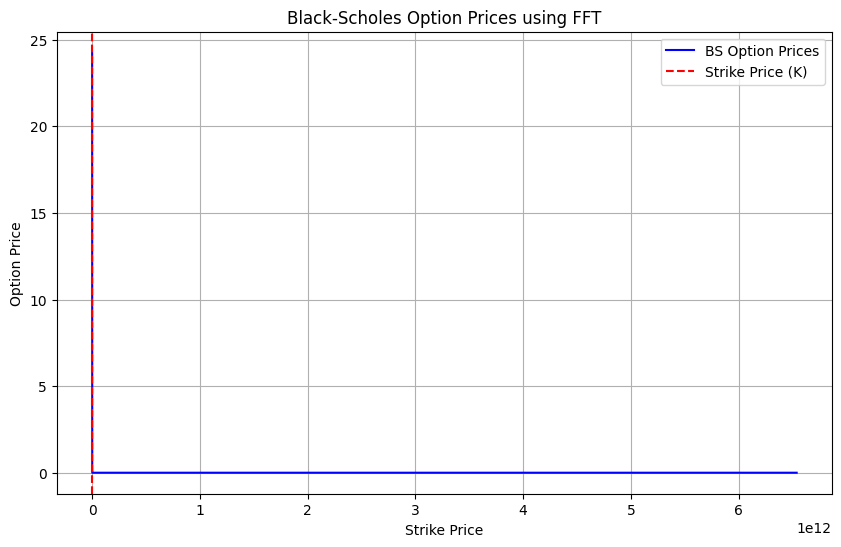

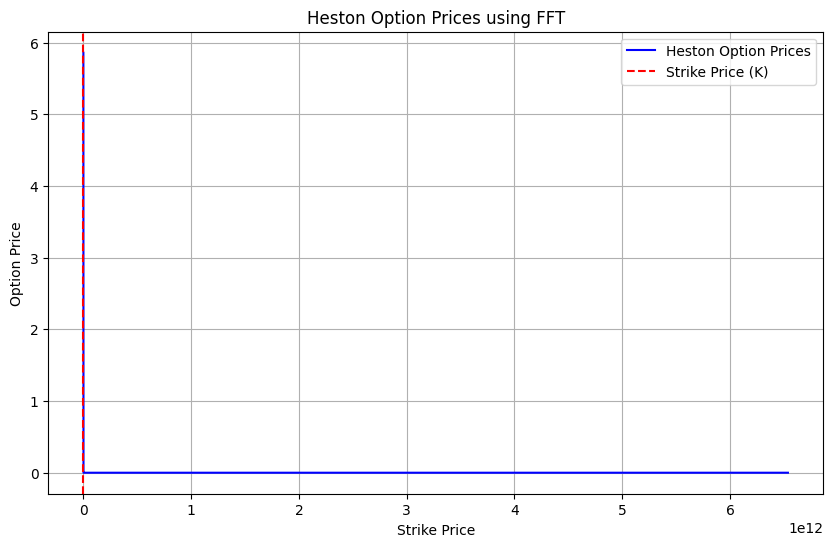

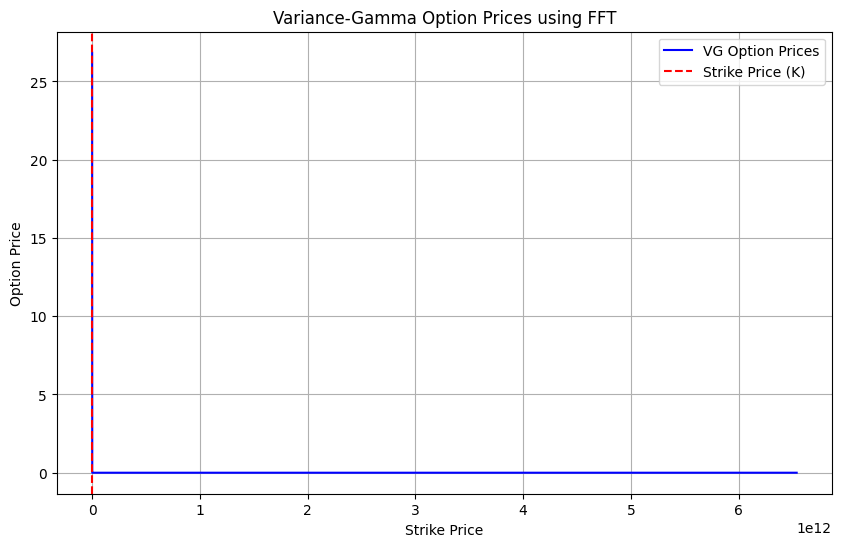

(array([8.00000000e+01, 8.04923829e+01, 8.09877964e+01, ...,
        6.45812468e+12, 6.49787306e+12, 6.53786608e+12], shape=(4096,)),
 array([2.68346379e+01, 2.64961987e+01, 2.61576939e+01, ...,
        3.38689475e-10, 3.34578641e-10, 3.30465659e-10], shape=(4096,)))

In [10]:
# Parameters for Black-Scholes
model = 'BS'
volatility = 0.3
params = [volatility]
price_options_and_plot(params, S0, K, r, q, T, alpha, eta, n, model, "Black-Scholes")

# Parameters for Heston
model = 'Heston'
kappa, theta, sigma, rho, v0 = 2.0, 0.05, 0.3, -0.7, 0.04
params = [kappa, theta, sigma, rho, v0]
price_options_and_plot(params, S0, K, r, q, T, alpha, eta, n, model, "Heston")

# Parameters for Variance-Gamma
model = 'VG'
sigma, nu, theta = 0.3, 0.5, -0.4
params = [sigma, nu, theta]
price_options_and_plot(params, S0, K, r, q, T, alpha, eta, n, model, "Variance-Gamma")


In [68]:
# Pricing Options using Fast Fourier Transform (FFT)
# This version uses real-life stock data from Yahoo Finance (yfinance)

# Importing Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Display settings for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)


In [75]:
# Fetch real-life stock data using yfinance
def fetch_stock_data(ticker, start_date, end_date):
    """
    Fetch stock data using yfinance and calculate additional metrics.
    
    Parameters:
        ticker (str): Stock ticker symbol (e.g., "AAPL" for Apple).
        start_date (str): Start date for the data (YYYY-MM-DD).
        end_date (str): End date for the data (YYYY-MM-DD).

    Returns:
        pd.DataFrame: DataFrame containing stock price and daily return.
    """
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    stock_data = stock_data[['Open', 'High', 'Low', 'Close', 'Volume']]  # Select relevant columns
    stock_data['Daily Return'] = stock_data['Close'].pct_change()  # Calculate daily returns
    stock_data.dropna(inplace=True)
    return stock_data

# Example: Fetch data for Apple (AAPL)
ticker = "AMZN"
start_date = "2024-01-01"
end_date = "2024-12-31"

stock_data = fetch_stock_data(ticker, start_date, end_date)

# Display the stock data
print(f"Stock data for {ticker}:")
stock_data.tail(10)


[*********************100%***********************]  1 of 1 completed

Stock data for AMZN:


Price,Open,High,Low,Close,Volume,Daily Return
Ticker,AMZN,AMZN,AMZN,AMZN,AMZN,
Date,,,,,,
2024-12-16,230.23,233.00,228.01,232.93,37552100,0.02
2024-12-17,232.39,232.73,227.85,231.15,35948100,-0.01
2024-12-18,230.77,231.40,220.11,220.52,43281400,-0.05
2024-12-19,224.91,226.09,222.92,223.29,39918700,0.01
2024-12-20,219.84,226.21,218.73,224.92,88279200,0.01
2024-12-23,225.01,226.88,223.90,225.06,28070000,0.00
2024-12-24,226.94,229.14,226.13,229.05,15007500,0.02
2024-12-26,228.50,228.50,226.67,227.05,16146700,-0.01


In [76]:
# General Parameters for Option Pricing
S0 = float(stock_data['Close'].iloc[-1])  # Convert to scalar (float)
K = S0 * 1.05                            # Strike price (5% above current stock price)
k = np.log(K)                            # Log strike price
r = 0.03                                 # Risk-free interest rate
q = 0.01                                 # Dividend yield
T = 0.5                                  # Time to maturity (6 months)

# FFT Parameters
n = 12                                   # Exponent for 2^n
N = 2 ** n                               # Number of steps
eta = 0.25                               # Integration step size
alpha = 1.0                              # Damping factor
lambda_ = (2 * np.pi / N) / eta          # Log-strike step size
beta = np.log(K)                         # Log-strike value

# Display Parameters
print(f"Option Pricing Parameters for {ticker}:")
pd.DataFrame({
    'Parameter': ['Initial Stock Price (S0)', 'Strike Price (K)', 'Risk-free Rate (r)', 
                  'Dividend Yield (q)', 'Time to Maturity (T)', 'FFT Steps (N)', 
                  'Integration Step Size (eta)', 'Damping Factor (alpha)'],
    'Value': [S0, K, r, q, T, N, eta, alpha]
})


Option Pricing Parameters for AMZN:


C:\Users\awadh\AppData\Local\Temp\ipykernel_32484\3575711192.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S0 = float(stock_data['Close'].iloc[-1])  # Convert to scalar (float)


,Parameter,Value
0,Initial Stock Price (S0),219.39
1,Strike Price (K),230.36
2,Risk-free Rate (r),0.03
3,Dividend Yield (q),0.01
4,Time to Maturity (T),0.50
5,FFT Steps (N),4096.00
6,Integration Step Size (eta),0.25
7,Damping Factor (alpha),1.00


In [77]:
# Function to Compute Characteristic Function
def compute_characteristic_function(u, params, S0, r, q, T, model):
    """
    Calculate the characteristic function for different option pricing models.

    Parameters:
        u (array): Complex inputs for the Fourier transform.
        params (list): Model-specific parameters.
        S0 (float): Current stock price.
        r (float): Risk-free interest rate.
        q (float): Dividend yield.
        T (float): Time to maturity.
        model (str): Option pricing model ("BS" for Black-Scholes).

    Returns:
        np.ndarray: Values of the characteristic function.
    """
    if model == 'BS':  # Black-Scholes
        volatility = params[0]
        drift = np.log(S0) + (r - q - 0.5 * volatility**2) * T
        diffusion = volatility * np.sqrt(T)
        phi = np.exp(1j * drift * u - 0.5 * (diffusion * u)**2)
    elif model == 'Heston':  # Heston
        kappa, theta, sigma, rho, v0 = params
        temp1 = kappa - 1j * rho * sigma * u
        g = np.sqrt(sigma**2 * (u**2 + 1j * u) + temp1**2)
        power_term = 2 * kappa * theta / sigma**2
        log_numerator = np.log(np.cosh(g * T / 2) + (temp1 / g) * np.sinh(g * T / 2))
        log_denominator = (u**2 + 1j * u) * v0 / (g / np.tanh(g * T / 2) + temp1)
        phi = np.exp(1j * u * np.log(S0) + r * T * 1j * u - log_numerator - log_denominator)
    elif model == 'VG':  # Variance-Gamma
        sigma, nu, theta = params
        if nu == 0:
            mu = np.log(S0) + (r - q - theta - 0.5 * sigma**2) * T
            phi = np.exp(1j * u * mu) * np.exp((1j * theta * u - 0.5 * sigma**2 * u**2) * T)
        else:
            mu = np.log(S0) + (r - q + np.log(1 - theta * nu - 0.5 * sigma**2 * nu) / nu) * T
            phi = np.exp(1j * u * mu) * ((1 - 1j * nu * theta * u + 0.5 * nu * sigma**2 * u**2)**(-T / nu))
    return phi


In [78]:
# FFT Function to Calculate Option Prices
def calculate_fft_values(params, S0, K, r, q, T, alpha, eta, n, model):
    """
    Calculate option prices using FFT.

    Parameters:
        params (list): Model-specific parameters.
        S0 (float): Current stock price.
        K (float): Strike price.
        r (float): Risk-free interest rate.
        q (float): Dividend yield.
        T (float): Time to maturity.
        alpha (float): Damping factor.
        eta (float): Integration step size.
        n (int): FFT exponent (2^n points).
        model (str): Option pricing model.

    Returns:
        tuple: Log-strike values and option prices.
    """
    N = 2 ** n
    delta = (2 * np.pi / N) / eta
    beta = np.log(K)
    
    # Discount Factor
    discount_factor = np.exp(-r * T)
    
    # Range of Integration (nu_j)
    nuJ = np.arange(N) * eta
    psi_nuJ = compute_characteristic_function(nuJ - (alpha + 1) * 1j, params, S0, r, q, T, model) / (
        (alpha + 1j * nuJ) * (alpha + 1 + 1j * nuJ)
    )
    
    # FFT Computation
    km_values = beta + delta * np.arange(N)
    w_values = eta * np.ones(N)
    w_values[0] = eta / 2  # Adjusting the first weight
    x_values = np.exp(-1j * beta * nuJ) * discount_factor * psi_nuJ * w_values
    y_values = np.fft.fft(x_values)
    cT_km_values = (np.exp(-alpha * km_values) / np.pi) * np.real(y_values)
    
    return km_values, cT_km_values


In [73]:
# Pricing Options for Black-Scholes, Heston, and Variance-Gamma Models
def price_options_and_plot(params, S0, K, r, q, T, alpha, eta, n, model, title):
    km_values, cT_km_values = calculate_fft_values(params, S0, K, r, q, T, alpha, eta, n, model)
    
    # Convert Log-Strike to Normal Strike Prices
    strikes = np.exp(km_values)
    
    # Create a DataFrame for Results
    results = pd.DataFrame({'Strike Price': strikes, 'Option Price': cT_km_values})
    
    # Plotting the Results
    #plt.figure(figsize=(10, 6))
    #plt.plot(strikes, cT_km_values, label=f"{model} Option Prices", color='blue')
    #plt.axvline(x=K, color='red', linestyle='--', label='Strike Price (K)')
    #plt.title(f"{title} Option Prices using FFT")
    #plt.xlabel("Strike Price")
    #plt.ylabel("Option Price")
    #plt.legend()
    #plt.grid(True)
    #plt.show()
    
    return results


In [ ]:
# Fetch Option Chain using yfinance
def fetch_option_chain(ticker, expiration_date):
    """
    Fetch option chain for a given ticker and expiration date.

    Parameters:
        ticker (str): Stock ticker symbol.
        expiration_date (str): Expiration date (YYYY-MM-DD).

    Returns:
        pd.DataFrame: Option chain data.
    """
    stock = yf.Ticker(ticker)
    option_chain = stock.option_chain(expiration_date)
    calls = option_chain.calls
    return calls

# Example: Fetch option chain for AAPL
expiration_date = "2025-01-03"  # Example expiration date
option_chain = fetch_option_chain(ticker, expiration_date)

# Display Option Chain
option_chain[['strike', 'lastPrice', 'impliedVolatility', 'volume']].head()


ValueError: Expiration `2024-12-03` cannot be found. Available expirations are: [2025-01-03, 2025-01-10, 2025-01-17, 2025-01-24, 2025-01-31, 2025-02-07, 2025-02-21, 2025-03-21, 2025-04-17, 2025-05-16, 2025-06-20, 2025-07-18, 2025-08-15, 2025-09-19, 2025-12-19, 2026-01-16, 2026-06-18, 2026-12-18, 2027-01-15]

In [64]:
# Black-Scholes Parameters
model = 'BS'
volatility = stock_data['Daily Return'].std() * np.sqrt(252)  # Annualized volatility
params = [volatility]

print(f"Pricing options for {ticker} using Black-Scholes Model:")
bs_results = price_options_and_plot(params, S0, K, r, q, T, alpha, eta, n, model, "Black-Scholes")
print(bs_results.head())


Pricing options for AMZN using Black-Scholes Model:
   Strike Price  Option Price
0        230.60         13.70
1        232.02         13.17
2        233.45         12.66
3        234.89         12.16
4        236.33         11.67


In [65]:
# Plot Comparison of FFT Prices and Real Option Prices
def plot_comparison(strikes, fft_prices, real_prices):
    """
    Compare FFT option prices with real-world option prices.

    Parameters:
        strikes (array): Strike prices.
        fft_prices (array): Prices from FFT computation.
        real_prices (pd.Series): Real-world option prices.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(strikes, fft_prices, label="FFT Option Prices", color="blue")
    plt.scatter(real_prices.index, real_prices.values, color="red", label="Real Option Prices")
    plt.axvline(x=K, color="green", linestyle="--", label="Strike Price (K)")
    plt.title(f"Comparison of FFT Option Prices and Real Option Prices for {ticker}")
    plt.xlabel("Strike Price")
    plt.ylabel("Option Price")
    plt.legend()
    plt.grid(True)
    plt.show()




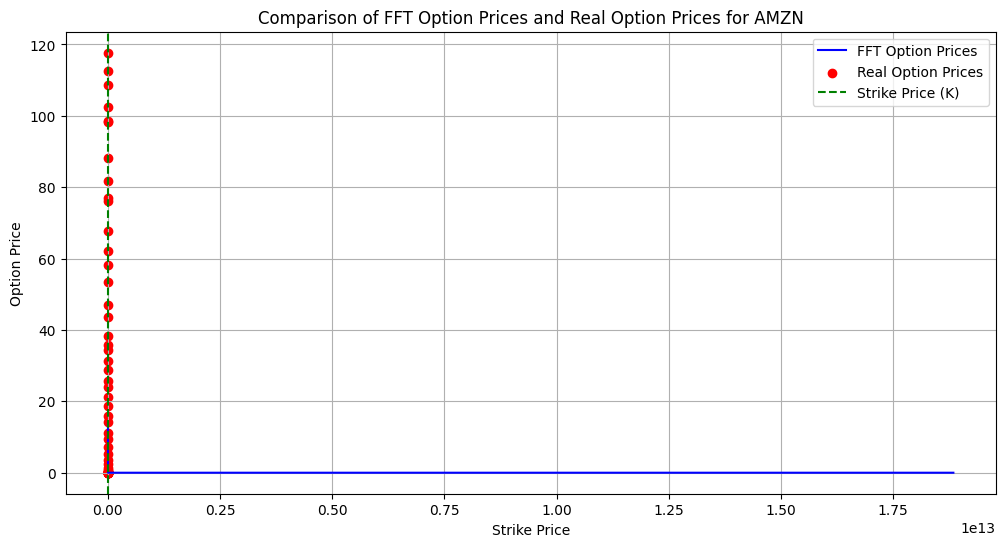

In [66]:



# Calculate FFT values using the Black-Scholes model
km_values, cT_km_values = calculate_fft_values(params, S0, K, r, q, T, alpha, eta, n, model)

# Extract Real Prices
real_prices = option_chain.set_index('strike')['lastPrice']
fft_strikes = np.exp(km_values)
fft_prices = cT_km_values

# Plot Comparison of FFT Prices and Real Option Prices
plot_comparison(fft_strikes, fft_prices, real_prices)
